<div align="center">
  <a href="https://www.davivienda.com/wps/portal/personas/nuevo">
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" alt="Logo" width="300" height="100">
  </a>

  <h2 align="center">Prueba Técnica Davivienda ADNe - Especialista I</h2>
  <h2 align="center">Notebook de Implementación Extracción de Opiniones Tweets</h2>
  <h4 align="center">Luvan Tabares</h4>
    
***

  <p align="left">
    Se requiere desarrollar una analítica preliminar de un conjunto de tweets que mencionan a nuestra organización. Utilizando herramientas de procesamiento de lenguaje natural (NLP), se procesarán los textos de los tweets para encontrar insights relevantes para áreas como marketing y servicio al cliente. Se busca visualizar estos datos de forma clara para los tomadores de decisiones y agrupar los tweets en categorías que permitan una buena analítica descriptiva de las opiniones de los clientes en Twitter. Para este desarrollo se usará una potente herramienta de clasificación de tópicos llamada BERTopic, capaz de analizar textos sin necesidad de realizar limpiezas y entendiendo su contexto para elegir los tópicos, siendo capaz de organizar un tópico especial para textos irrelevantes, lo que ayuda a reducir el análisis.
    
  </p>
</div>

## Tabla de contenidos

1. [Instalación de librerías y llamado de librerías](#first1) <br />
2. [Pequeña exploración de datos](#second1) <br />
3. [Extracción de tópicos](#third1) <br />
4. [Análisis de sentimiento](#fourth) <br />

## 1. Librerias a instalar <a id="first1"></a>

In [1]:
# !pip install -r requirements.txt


"""
pip install pandas seaborn transformers bertopic nbformat





"""

'\npip install pandas seaborn transformers bertopic nbformat\n\n\n\n\n\n'

## Cargar las librerías necesarias

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
import re


## 2. Pequeña exploración de datos <a id="second1"></a>

In [3]:
### Se inicia cargando el archivo csv
csv_file_path = 'data_original/Tweets/davivienda_tweets.csv'
### Se carga el archivo csv en un dataframe
df = pd.read_csv(csv_file_path)

In [4]:
# Se imprime el encabezado del dataframe
df.head()

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


### Una vez revisados los textos, normalmente se realiza una limpieza de los mismos. Sin embargo, debido al uso de la herramienta BERTopic, no será necesario realizar preprocesamientos. Al contrario, con este modelo, las StopWords pueden proporcionar un contexto valioso que se perdería si fueran eliminadas. Además, considerando que los textos a analizar son tweets, que son generalmente cortos, eliminar información podría resultar en una pérdida de contexto importante.

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)
# Se revisará la longitud de los tweets
df["headline_text_len"] = df["Embedded_text"].apply(lambda x : len(x.split()))

In [6]:
# La longitud de los tweets máxima y mínima
print("The longest headline has: {} words".format(df.headline_text_len.max()))
print("The shortest headline has: {} words".format(df.headline_text_len.min()))

The longest headline has: 101 words
The shortest headline has: 4 words


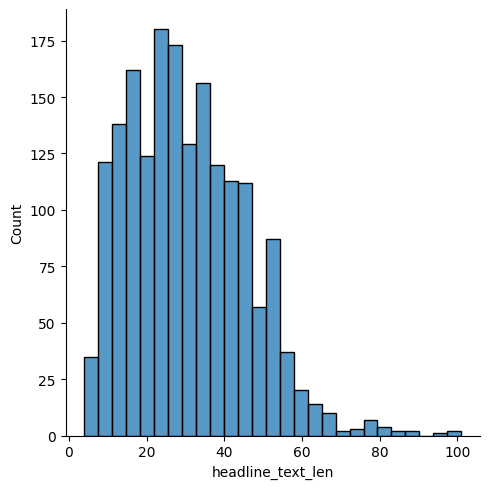

In [7]:
# Se visualiza la distribución de la longitud de los tweets
sns.displot(df.headline_text_len, kde=False)

### En este caso, aunque precipitado, se podría decir que tanto tweets demasiado largos como tweets demasiado cortos no deberían aportar información relevante, siendo ambos casos posibles spams o la citación de múltiples personas en el mismo tweet. Podría considerarse a futuro la eliminación de estos casos con precaución, para este análisis se tomarán todos los casos.

In [8]:
# Ahora se visualizan algunos ejemplos de tweets
for idx in df.sample(3).index:  # Itera sobre los índices de 3 muestras aleatorias del DataFrame df.
    headline = df.iloc[idx]  # Obtiene la fila correspondiente al índice actual.
    print("Headline #{}:".format(idx))  # Imprime el número de la noticia actual.
    print("Publication date: {}".format(headline.Timestamp))  # Imprime la fecha de publicación de la noticia.
    print("Text: {}\n".format(headline.Embedded_text))  # Imprime el texto de la noticia.

Headline #270:
Publication date: 2021-12-06T18:57:00.000Z
Text: En respuesta a 
@Davivienda
Llevan diciendo los mismo desde hace 5 días y aún sigo sin el pago de mi sueldo... Para colmo quedaron en llamar y no han llamado ni enviado el mensaje del cambio ... Su atención al cliente es la peor que he visto en años.

Headline #1636:
Publication date: 2021-12-21T14:59:39.000Z
Text: En respuesta a 
@Asnasalvaje
 y 
@Davivienda
A mi me quedaron tres mil pesitos ojalá no se los roben.

Headline #1443:
Publication date: 2021-12-19T19:11:11.000Z
Text: Jajajajaja yo creo además se esconde en entidades bancarias repletas como 
@Davivienda
 @BancoPopularCR
 @Banco_AvVillas
 @BancodeBogota
 banco de occidente en estos en especial el covid no funciona
farmaceuticoactivo
@farmaceuticoac1
 · 18 dic.
Una pregunta los virus saben leer ? Será que el virus ve el pase sanitario y se asusta ?
1



## 3. Extracción de tópicos <a id="third1"></a>

In [9]:
# Continuado con el desarrollo se procede a realizar el análisis de tópicos
# Se crea el modelo BERTopic
# Se establece el parámetro embedding_model='paraphrase-MiniLM-L3-v2' para utilizar el modelo de lenguaje MiniLM.
# Se establece el parámetro min_topic_size para que se creen tópicos con un n tweets.
# Se establece el parámetro language="multilingual" para que el modelo sea capaz de procesar texto en varios idiomas.
# Se establece el parámetro nr_topics='auto' para que el modelo determine automáticamente el número de tópicos y evitar tópicos comunes
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 3, language="multilingual", nr_topics='auto')


# Se ajusta el modelo a los tweets
# Se extraen los tópicos y las palabras clave de los tópicos
headline_topics, _ = model.fit_transform(df.Embedded_text)

2024-07-20 01:17:47,430 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 57/57 [00:00<00:00, 106.71it/s]
2024-07-20 01:17:49,048 - BERTopic - Embedding - Completed ✓
2024-07-20 01:17:49,048 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-20 01:17:58,832 - BERTopic - Dimensionality - Completed ✓
2024-07-20 01:17:58,832 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-20 01:17:58,876 - BERTopic - Cluster - Completed ✓
2024-07-20 01:17:58,876 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-20 01:17:58,952 - BERTopic - Representation - Completed ✓
2024-07-20 01:17:58,953 - BERTopic - Topic reduction - Reducing number of topics
2024-07-20 01:17:59,018 - BERTopic - Topic reduction - Reduced number of topics from 106 to 85


### Durante el desarrollo se observó que ajustar la cantidad de min_topic_size podría mejorar el filtrado de la información. Inicialmente se usaron 10 tópicos mínimos, lo que agrupaba todos los mensajes de Davivienda en una sola categoría, impidiendo la extracción de información relevante. Esto se debe a que Davivienda utiliza una plantilla de respuestas para asistir a los usuarios o disculparse en caso de fallas del servicio. Por esta razón, se redujo el número mínimo de tópicos para mejorar la identificación de temas. Con min_topic_size establecido en 10, los tweets con respuestas tipo plantilla de Davivienda se consideraban como tópicos importantes. Al reducir el valor a 5 o menos, estos mensajes de plantilla aparecieron con el tópico -1, indicando que para el modelo estos mensajes son irrelevantes y, por lo tanto, no deben ser revisados ya que son redundantes. Un problema que se tiene

In [10]:
# Obtener información sobre los temas del modelo
freq = model.get_topic_info()  
# Imprimir el número de temas identificados por el modelo
print("Number of topics: {}".format(len(freq)))  
# Mostrar el DataFrame 'freq' que contiene la información de los temas
freq.head(10)

Number of topics: 85


,Topic,Count,Name,Representation,Representative_Docs
0,-1,507,-1_en_que_davivienda_no,"[en, que, davivienda, no, me, de, el, respuest...",[En respuesta a \n@Bancolombia\nte cuento por ...
1,0,174,0_en_respuesta_la_que,"[en, respuesta, la, que, el, lugar, equivocado...",[En respuesta a \n@wilsonariasc\n y \n@Davivie...
2,1,133,1_respondiendo_más_edimejia1979_marianiniecheve,"[respondiendo, más, edimejia1979, marianiniech...",[Respondiendo a \n@Edimejia1979\n @NoticiasRCN...
3,2,107,2_lamentamos_gusto_inconvenientes_validaremos,"[lamentamos, gusto, inconvenientes, validaremo...",[En respuesta a \n@ntcoral\nBuenos días. Lamen...
4,3,62,3_respuesta_asnasalvaje_davivienda_en,"[respuesta, asnasalvaje, davivienda, en, envié...",[En respuesta a \n@Asnasalvaje\nEn Davivienda ...
5,4,58,4_solución_hermano_daviplata_discapacitado,"[solución, hermano, daviplata, discapacitado, ...",[Señores \n@SFCsupervisor\n como es posible qu...
6,5,54,5_cuenta_mi_ahorros_cuentas,"[cuenta, mi, ahorros, cuentas, nequi, de, la, ...",[Provablemente alguien del mismo davivienda qu...
7,6,49,6_mejorar_experiencia_trabajamos_continuamente,"[mejorar, experiencia, trabajamos, continuamen...",[En respuesta a \n@ntcoral\nBuenos días. Traba...
8,7,39,7_dinero_me_el_pague,"[dinero, me, el, pague, de, ahora, cuando, sfc...",[Y resulta que ahora en los pagos por PSE no m...
9,8,31,8_wilsonariasc_deshacen_respuesta_señor,"[wilsonariasc, deshacen, respuesta, señor, pro...",[En respuesta a \n@wilsonariasc\n y \n@Davivie...


### Se observa que la cantidad de tópicos -1 es bastante elevada, en este caso es normal, la única manera de mejorar y reducir la detección de los textos irrelevantes es mejorar la tokenización e incluso probar otros modelos, se intentó usar la tokenización de spacy y el modelo en español pero no hubo mejoras

### En la siguiente celda se puede observar más detalladamente cada texto analizado, con su topic asignado, un nombre, las palabras claves más representativas y otras métricas.

In [11]:
model.get_document_info(df.Embedded_text)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,La confianza se afectó. El indicador de confia...,0,0_en_respuesta_la_que,"[en, respuesta, la, que, el, lugar, equivocado...",[En respuesta a \n@wilsonariasc\n y \n@Davivie...,en - respuesta - la - que - el - lugar - equiv...,0.781838,False
1,Buscamos la accesibilidad y mejor atención en ...,59,59_cambian_algunas_horarios_contamos,"[cambian, algunas, horarios, contamos, colombi...",[@BANCOLOMBIA\n Me parece 1 bofetada a los col...,cambian - algunas - horarios - contamos - colo...,0.708584,False
2,Señores \n@Davivienda\n no he podido ingresar ...,16,16_ingresar_ayudar_permite_fallas,"[ingresar, ayudar, permite, fallas, me, tratan...",[Señores \n@Davivienda\n no he podido ingresar...,ingresar - ayudar - permite - fallas - me - tr...,0.606565,True
3,Llevo toda una semana sufriendo intento de hur...,5,5_cuenta_mi_ahorros_cuentas,"[cuenta, mi, ahorros, cuentas, nequi, de, la, ...",[Provablemente alguien del mismo davivienda qu...,cuenta - mi - ahorros - cuentas - nequi - de -...,1.000000,False
4,Hemos retrocedido tanto en este país con este ...,-1,-1_en_que_davivienda_no,"[en, que, davivienda, no, me, de, el, respuest...",[En respuesta a \n@Bancolombia\nte cuento por ...,en - que - davivienda - no - me - de - el - re...,0.000000,False
...,...,...,...,...,...,...,...,...
1806,En respuesta a \n@JaimeMolina\nBuenas tardes. ...,-1,-1_en_que_davivienda_no,"[en, que, davivienda, no, me, de, el, respuest...",[En respuesta a \n@Bancolombia\nte cuento por ...,en - que - davivienda - no - me - de - el - re...,0.000000,False
1807,"En respuesta a \n@josefe71\nHola Jose , gracia...",6,6_mejorar_experiencia_trabajamos_continuamente,"[mejorar, experiencia, trabajamos, continuamen...",[En respuesta a \n@ntcoral\nBuenos días. Traba...,mejorar - experiencia - trabajamos - continuam...,0.408190,False
1808,En respuesta a \n@gleniiaaa\nHola! Bienvenida ...,26,26_laura_canal_atención_envíenos,"[laura, canal, atención, envíenos, nuestro, ha...",[En respuesta a \n@GomezCZ\nBienvenida a nuest...,laura - canal - atención - envíenos - nuestro ...,1.000000,False
1809,"En respuesta a \n@diegoruix\nBuenos días, Sr. ...",13,13_evidenciamos_novedad_inquietud_adicional,"[evidenciamos, novedad, inquietud, adicional, ...",[En respuesta a \n@pepalf\nBuenas tardes. Evid...,evidenciamos - novedad - inquietud - adicional...,1.000000,False


### Es posible que a pesar de usar filtros como nr_topics='auto' que activa el HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) que es un algoritmo de clustering avanzado con detección con características como: 

### Densidad Variable: HDBSCAN puede identificar clusters en datos con densidades variadas, mientras que DBSCAN requiere una densidad constante.
### Jerarquía de Clusters: HDBSCAN construye una jerarquía de clusters, permitiendo analizar la estructura de los datos a diferentes niveles de granularidad.
### Identificación de Ruido: Al igual que DBSCAN, HDBSCAN puede identificar puntos de datos que no pertenecen a ningún cluster (ruido).
### Automatización de Parámetros: puede automatizar la elección de algunos parámetros que en DBSCAN deben ser ajustados manualmente, como el radio de búsqueda

### Aún con esto se pueden tener topicos duplicados, por lo que se realizará un breve análisis al respecto

In [12]:
### Se visualizan los tópicos y su similaridad, en la gráfica la misma tonalidad sugiere tópicos muy cercanos que se podrían unir
model.visualize_heatmap(n_clusters=len(freq)/2)

In [13]:
# Calcular la similitud coseno entre los embeddings de los temas y almacenarla en una matriz de distancia
distance_matrix = cosine_similarity(np.array(model.topic_embeddings_))

# Convertir la matriz de distancia en un DataFrame para facilitar su manipulación, estableciendo columnas e índice con las etiquetas de los temas
dist_df = pd.DataFrame(distance_matrix, columns=model.topic_labels_.values(), index=model.topic_labels_.values())

# Inicializar una lista vacía para almacenar las distancias por pares entre temas
tmp = []

# Convertir el DataFrame de distancia en un diccionario de registros y iterar sobre él
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']  # El campo 'index' representa el primer tema en el par
    for t2 in rec:  # Iterar sobre todos los temas para calcular distancias por pares
        if t2 == 'index':  # Saltar el campo 'index' ya que no es un tema
            continue
        # Añadir un diccionario con los temas y su distancia a la lista
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

# Convertir la lista de diccionarios en un DataFrame para facilitar su manipulación
pair_dist_df = pd.DataFrame(tmp)

# Filtrar los pares donde alguno de los temas esté etiquetado como '-1' (generalmente representa ruido o temas no clasificados)
pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]

# Asegurar que cada par sea único filtrando duplicados invertidos
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]

# Ordenar el DataFrame por distancia en orden descendente y mostrar los 20 pares superiores
pair_dist_df.sort_values('distance', ascending = False).head(20)

,topic1,topic2,distance
3450,39_noticiasrcn_colombia_piloto_binance,49_colombia_aliado_binancees_ilegal,0.934848
397,3_respuesta_asnasalvaje_davivienda_en,56_obvioooooo_mariobotinat_invito_binance_col,0.934353
109,0_en_respuesta_la_que,23_cuenta_ayúdame_abrir_sorpresa,0.921997
124,0_en_respuesta_la_que,38_plata_ilusion_mental_cierta_veh,0.921762
3153,36_cierra_te_dolar_bajarle,7_dinero_me_el_pague,0.920686
131,0_en_respuesta_la_que,45_reconocimiento_pedorros_manejas_yopucheros,0.917650
105,0_en_respuesta_la_que,19_asnasalvaje_llama_queja_repetitiva,0.916018
2388,27_plataforma_verifique_datos_presentando,7_dinero_me_el_pague,0.915951
143,0_en_respuesta_la_que,57_cuota_suministro_crecimiento_lastrar,0.915603
4088,47_sinpe_cajero_transacción_electrónico,7_dinero_me_el_pague,0.914904


### Se observan que hasta arriba algunos temas podrían ser efectivamente similares, por lo que se podrían unir para reducir la cantidad de tópicos

In [14]:
# Se define función para extraer los números de los temas con una distancia superior a 0.9
def extract_numbers(row):
    # Si la distancia entre los temas es mayor a 0.9
    if row['distance'] > 0.9:
        # Extrae el número del primer tema usando expresiones regulares y lo convierte a entero
        num1 = int(re.match(r'(\d+)_', row['topic1']).group(1))
        # Extrae el número del segundo tema usando expresiones regulares y lo convierte a entero
        num2 = int(re.match(r'(\d+)_', row['topic2']).group(1))
        # Retorna una lista con los números extraídos
        return [num1, num2]
    else:
        # Si la distancia es menor o igual a 0.9, retorna una lista vacía
        return []

# Aplica la función a cada fila del DataFrame y crea una nueva columna 'numbers' con la lista de números
pair_dist_df['numbers'] = pair_dist_df.apply(extract_numbers, axis=1)

In [15]:
# Convertir la columna 'numbers' del DataFrame en una lista de listas
lista_temas_similares = pair_dist_df['numbers'].tolist()
# Filtrar la lista para eliminar las listas vacías, manteniendo solo aquellas con números de temas similares
filtered_lista_temas_similares = [lst for lst in lista_temas_similares if lst]
# Utilizar el modelo para fusionar los temas en el DataFrame 'df' basado en los números de temas similares identificados
try:
    model.merge_topics(df.Embedded_text, filtered_lista_temas_similares)

    # Actualiza el modelo con los temas fusionados para obtener la distribución de temas y tokens
    # Se utiliza la función approximate_distribution del modelo
    topic_distr, topic_token_distr = model.approximate_distribution(
        df.Embedded_text,  # Se pasa el texto embebido del DataFrame como entrada
        window = 4,  # Se define una ventana de 4 para considerar el contexto local alrededor de cada palabra
        calculate_tokens=True)  # Se habilita el cálculo de la distribución de tokens además de la de temas

except Exception as e:
    print("No hubo necesidad de fusionar temas similares, los temas no superaron el 90% de similitud")

100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


In [16]:
# Ahora se pueden extraer las primeras dos palabras de cada tópico para generar nombres de tópicos más descriptivos
def extract_first_two_words(word_list):
    return " ".join(word_list[:2])

In [17]:
#Se asigna una variable a la lista de tópicos
df_topics = model.get_document_info(df.Embedded_text)
# Se añade la columna 'Topic' al DataFrame reemplazando los números por palabras descriptivas
df['Topic'] = df_topics['Representation'].apply(extract_first_two_words)

In [18]:
# Se revisa si la cantidad de tópicos disminuyó en caso de que se hayan fusionado tópicos similares
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))

Number of topics: 73


### En la siguiente celda se puede observar la columna Topic agregada al dataframe

In [19]:
df.drop_duplicates(subset=['Topic']).head(10)

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,headline_text_len,Topic
0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...,45,en respuesta
1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...,32,algunas cambian
2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...,25,ingresar ayudar
3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...,52,cuenta mi
4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...,34,en que
6,Universidad El Bosque,@U_ElBosque,2021-12-01T15:00:26.000Z,Universidad El Bosque\n@U_ElBosque\n·\n1 dic.,Conoce los requisitos de la convocatoria de Be...,NaN,NaN,NaN,NaN,['https://pbs.twimg.com/media/FFh9c8jXsAAtEXc?...,https://twitter.com/U_ElBosque/status/14660596...,15,com de
7,Cristian Julian,@cjulianlozano,2021-12-01T00:01:49.000Z,Cristian Julian\n@cjulianlozano\n·\n30 nov.,Mamado de ser adulto y tener que trabajar para...,NaN,NaN,NaN,NaN,[],https://twitter.com/cjulianlozano/status/14658...,12,equivocado lugar
8,Santiago Parra Angel,@SantiagoParraA2,2021-12-01T01:31:18.000Z,Santiago Parra Angel\n@SantiagoParraA2\n·\n30 ...,"#daviplata ayuda por favor, llevo más de 3 mes...",NaN,NaN,NaN,1,[],https://twitter.com/SantiagoParraA2/status/146...,44,solución hermano
12,Juliana,@JulianaUssa3,2021-12-01T17:33:05.000Z,Juliana\n@JulianaUssa3\n·\n1 dic.,Nunca usen los servicios de \n@DaviPlata\n @Ra...,NaN,2.0,NaN,1,[],https://twitter.com/JulianaUssa3/status/146609...,18,aplicación nunca
14,Andrea Cabana D.,@andreaCabanaD,2021-12-01T13:24:36.000Z,Andrea Cabana D.\n@andreaCabanaD\n·\n1 dic.,Me quiero ir de \n@Bancolombia\n. Pero no a Da...,NaN,3.0,NaN,NaN,[],https://twitter.com/andreaCabanaD/status/14660...,13,bancolombia vida


## 4. Análisis de sentimiento <a id="fourth"></a>

### En Hugging Face se encontró el modelo pysentimiento/robertuito-sentiment-analysis que es un modelo entrenado en español para detectar el sentimiento de los tweets, modelo entrenado con alrededor de 5000 tweets lo hace un modelo interesante para analizar los sentimientos en un tweet en español

In [20]:
from transformers import pipeline
sentiment_analyzer = pipeline('sentiment-analysis', model='pysentimiento/robertuito-sentiment-analysis', device=0)

texts = df['Embedded_text'].tolist()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
for i in range(len(texts)):
    texts[i] = texts[i].replace("@", "")
    texts[i] = texts[i].replace("#", " ")
    texts[i] = texts[i].replace("\n", " ")
    texts[i] = re.sub(r"\s+", " ", texts[i]).strip()



In [22]:
from transformers import pipeline
import time

# Load the sentiment analysis pipeline with the Robertuito model
sentiment_analyzer = pipeline("sentiment-analysis", model="pysentimiento/robertuito-sentiment-analysis", device=0)

max_length = 128

sentiment_list = []
# Analyze the sentiment of each text
for text in texts:
    try:
        # Truncate the text to the maximum length
        truncated_text = text[:max_length]
        result = sentiment_analyzer(truncated_text)[0]
        label = result['label']
        sentiment_list.append(label)
    except Exception as e:
        print("Error al analizar el sentimiento")
        print(e)
        print(f"Texto: {text}")
        sentiment_list.append("Error")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [23]:
sentiment_list

['NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEU',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEU',
 'NEU',
 'NEG',
 'NEU',
 'NEU',
 'NEU',
 'NEU',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEU',
 'POS',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEU',
 'NEU',
 'NEG',
 'NEU',
 'NEU',
 'NEG',
 'NEG',
 'NEU',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'POS',
 'POS',
 'NEG',
 'POS',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'POS',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'POS',
 'NEU',
 'NEU',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEG',
 'NEU',
 'NEU',
 'NEU',
 'NEG',
 'POS',
 'NEG',
 'NEU',
 'NEU',
 'NEG',
 'POS',
 'NEG',
 'NEG',
 'NEG',
 'NEU',
 'NEU',
 'NEU',
 'POS',
 'NEU',
 'NEG',
 'POS',
 'NEG',
 'NEU',
 'NEU',
 'POS',
 'NEG',


In [24]:
# # Function to process texts in batches
# def batch_process(texts, batch_size):
#     results = []
#     for i in range(0, len(texts), batch_size):
#         batch = texts[i:i + batch_size]
#         batch_results = sentiment_analyzer(batch)
#         results.extend(batch_results)
#     return results

In [25]:

# lista_resultados = batch_process(texts, batch_size=3)

In [26]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4090


In [27]:
from transformers import pipeline

# Initialize the question-answering pipeline
question_answerer = pipeline("question-answering")

# Define the context and the question
context = "uno', 'confianza', 'mes', 'indicador"
question = "¿Cuál es el tema principal de este texto en una o dos palabras?"

# Get the answer from the pipeline
result = question_answerer(question=question, context=context)
print(f"Resumen: {result['answer']}")


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Resumen: indicador
